# HW2: Local Planning

### EECE 5550: Mobile Robotics (Spring 2025)


**Collaboration Statement:**

In [1]:
# Collaborated with Rohith Poola on the obstacle avoidance algorithm (2b). The rest of the code was written independently. Chatgpt was used for the obstacle avoidance as well.

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [2]:
# !pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git
# !pip uninstall -y gym-neu-racing

Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [3]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
import cvxpy as cp

# Problem 1: MPPI

## 1a) MPPI to move toward a goal coordinate

In this problem, you'll implement a basic version of MPPI and show that it outputs a good rollout to move a robot toward a given goal position. This part uses the Unicycle kinematic model that's built into the simulator. You should  make sure that your `get_action` method considers the control limits (otherwise it may command things that the robot can't execute), which may require passing those as arguments to the `__init__` method.

You will probably need to experiment with different numbers of rollouts, cost functions, λ values, numbers of iterations, etc. to get good performance.

Keeping this code relatively organized and clean will help for later parts in the assignment, where you build on this implementation. For example, you are encouraged to define helper methods in your `MPPI` class to help keep your code organized (e.g., you may want a `score_rollouts` and/or `plot_rollouts` method that get called inside the `get_next_action` method).

**Deliverables**:
- Implement the `MPPI` class, in particular the `get_next_action` method, so that the chosen rollout drives the robot toward the goal position.
- Print the best control sequence your MPPI algorithm came up with (the first row/element of this sequence should be the action that your `get_action` returns)
- Include a plot that shows the rollouts, start position, goal position, and highlights the best rollout in that iteration, for at least a few iterations. We expect that the later iterations will give much better rollouts than the first iteration. You should make your axes have the same scale (e.g., using `plt.axis('equal')`).

In [4]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [5]:
class MPPI:
    def __init__(
        self,
        motion_model=motion_models.Unicycle(),
        no_of_rollouts = 100,
        v_limits = [0,1],
        w_limits = [-2 * np.pi, 2 * np.pi],
        lam = 0.1,
        t = 10,
    ):
        """ Your implementation here """
        self.motion_model = motion_model
        self.no_of_rollouts = no_of_rollouts
        self.v_limits = v_limits
        self.w_limits = w_limits
        self.lam = lam
        self.t = t

    def control_disturbance_matrix(self):
        disturbances = np.random.normal(0, [0.5,np.pi], size=(self.no_of_rollouts, self.t, 2))
        return disturbances
    
    def score_rollouts(self, control_sequences, initial_state, goal_pos):
        scores = []
        for control_sequence in control_sequences:
            total_distance = 0
            state = initial_state
            for control in control_sequence:
                state = self.motion_model.step(state, control, 0.1)
                distance_to_goal = np.linalg.norm(state[:2] - goal_pos)
                velocity_penalty = 0
                # if distance_to_goal <= 0.1:
                #     velocity_penalty = 1 * np.linalg.norm(control)

                total_distance += distance_to_goal + velocity_penalty

            scores.append(total_distance)

        return scores
    
    def plot_rollouts(self, initial_state: np.ndarray, goal_pos: np.ndarray, control_sequences, action):
        plt.figure()

        for control_sequence in control_sequences:
            state = initial_state.copy()
            trajectory = [state[:2]]
            for control in control_sequence:
                state = self.motion_model.step(state, control, 0.1)
                trajectory.append(state[:2])
            plt.plot(*zip(*trajectory), color='gray', alpha=0.5)

        state = initial_state.copy()
        trajectory = [state[:2]]
        for control in action:
            state = self.motion_model.step(state, control, 0.1)
            trajectory.append(state[:2])
        plt.plot(*zip(*trajectory), color='green', label='Best Action', linewidth=2)
        plt.scatter(*initial_state[:2], color='blue', label='Initial Position')
        plt.scatter(*goal_pos, color='red', label='Goal Position')
        plt.axis('equal')
        plt.legend()
        plt.show()
            
    def get_action(self, initial_state: np.ndarray, goal_pos: np.ndarray):
        """ Your implementation here """
        # raise NotImplementedError
        nominal_control_sequence = np.array([[1, 2] for _ in range(self.t)])
        control_sequences = nominal_control_sequence + self.control_disturbance_matrix()
        control_sequences[:, :, 0] = np.clip(control_sequences[:, :, 0], self.v_limits[0], self.v_limits[1])  # v
        control_sequences[:, :, 1] = np.clip(control_sequences[:, :, 1], self.w_limits[0], self.w_limits[1])  # w
        scores = self.score_rollouts(control_sequences,initial_state, goal_pos)
        weights = np.exp(-np.array(scores) / self.lam)
        weights /= np.sum(weights)
        delta_u = control_sequences - nominal_control_sequence
        merged_sequence = nominal_control_sequence + np.sum((weights[:, None, None] * delta_u), axis=0) / np.sum(weights)
        self.plot_rollouts(initial_state,goal_pos,control_sequences,merged_sequence)
        print('Best control sequence:', merged_sequence)
        return merged_sequence[0]

You can use the following code to check whether your MPPI implementation is working. After tuning your algorithm, it should be able to come up with a rollout that ends close to the goal (within 0.1m in l2 distance is close enough):

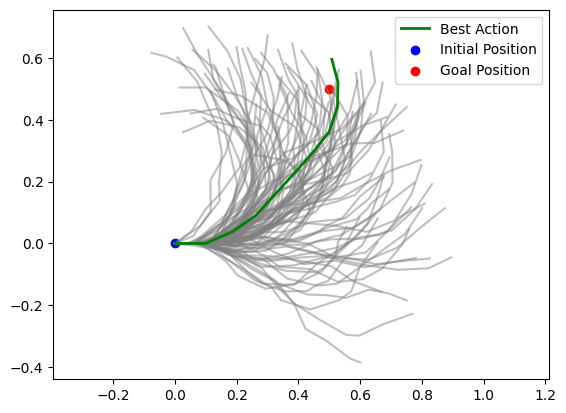

Best control sequence: [[0.99167003 4.09344281]
 [0.96013199 2.05339962]
 [0.91530993 2.13641075]
 [0.83872071 0.00748338]
 [0.96399589 0.15787   ]
 [0.97463679 0.57026823]
 [0.82066771 3.51541429]
 [0.86368098 2.93228896]
 [0.78652863 2.89262531]
 [0.76754635 3.700113  ]]


In [6]:
# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)
obs, _ = env.reset()

# Set the starting state (x, y, theta) and goal position (x, y).
initial_state = np.array([0.0, 0.0, 0.0])
goal_pos = np.array([0.5, 0.5])

# Instantiate your contoller class
controller = MPPI()

# Run your control algorithm for 1 step. We'll worry about running your
# algorithm in closed-loop in later parts of the assignment.
action = controller.get_action(initial_state, goal_pos)


## 1b) MPPI to drive around a racetrack

Now you will extend your MPPI implementation so that your robot drives around a racetrack. There are a few interesting challenges you'll need to figure out that didn't appear in the earlier problem:

*   How to score rollouts? Some possible ideas include placing waypoints around the track, designing a cost-to-go function, or encouraging the vehicle to maintain full speed, but this is completely up to you!
*   How to ensure the robot doesn't collide with the walls? You can transform coordinates from the world frame to map cell indices using `self.static_map.world_coordinates_to_map_indices(states_in_world)` and `self.static_map.static_map[map_indices]` to check whether a cell of the map is occupied or free.

**Deliverables**:
- Implement the `MPPIRacetrack` class below to enable your robot to complete a full lap around the track
- Generate a plot of the path taken with some indication of time (e.g., using a colorbar, timestamps every so often along the path, or another creative way you come up with)

In [7]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEURacing-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [ ]:
class MPPIRacetrack:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
        no_of_rollouts = 70,
        v_limits = [0,1],
        w_limits = [-2 * np.pi, 2 * np.pi],
        lam = 1000,
        t = 10,
    ):
        """ Your implementation here """
        self.motion_model = motion_model
        self.static_map = static_map
        # raise NotImplementedError
        self.no_of_rollouts = no_of_rollouts
        self.v_limits = v_limits
        self.w_limits = w_limits
        self.lam = lam
        self.t = t
        self.last_control = np.array([1,1])

    def control_disturbance_matrix(self):
        disturbances = np.random.normal(0, [0,2*np.pi], size=(self.no_of_rollouts, self.t, 2))
        return disturbances
    
    def score_rollouts(self, control_sequences, initial_state, goal_pos):
        scores = []
        for control_sequence in control_sequences:
            total_distance = 0
            state = initial_state
            for control in control_sequence:
                state = self.motion_model.step(state, control, 0.1)
                distance_to_goal = np.linalg.norm(state[:2] - goal_pos)
                map_indices = self.static_map.world_coordinates_to_map_indices(state[:2])
                collision_penalty = 0
                if self.static_map.static_map[map_indices[0][0]][map_indices[0][1]]:  # Collision with walls
                    collision_penalty = 1e6 # Large penalty for collisions
                total_distance += distance_to_goal*100 + collision_penalty

            scores.append(total_distance)

        return scores
            
    def get_action(self, initial_state: np.ndarray, waypoints: list = [[-2.5,0], [1,4], [3.5,0]]*4):
        """Compute the optimal action to navigate through waypoints."""

        # Select the next waypoint as the current goal
        goal_pos = waypoints[0]
        # print(f"Goal: {goal_pos}")
        nominal_control_sequence = np.array([self.last_control for _ in range(self.t)])
        control_sequences = nominal_control_sequence + self.control_disturbance_matrix()
        control_sequences[:, :, 0] = np.clip(control_sequences[:, :, 0], self.v_limits[0], self.v_limits[1])  # v
        control_sequences[:, :, 1] = np.clip(control_sequences[:, :, 1], self.w_limits[0], self.w_limits[1])  # w
        scores = self.score_rollouts(control_sequences, initial_state, goal_pos)
        # print(scores)
        weights = np.exp(-np.array(scores) / self.lam)
        weights /= np.sum(weights)
        delta_u = control_sequences - nominal_con                         trol_sequence
        merged_sequence = nominal_control_sequence + np.sum((weights[:, None, None] * delta_u), axis=0)

        # Check if the robot is close enough to the current waypoint to move to the next
        if np.linalg.norm(initial_state[:2] - goal_pos) < 0.5:  # Threshold distance
            waypoints.append(waypoints.pop(0))  # Move to the next waypoint (loop)

        self.last_control = merged_sequence[0]

        return merged_sequence[0]


Initial position: [ 0.8392881  -3.78481063  3.24435603]
lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed


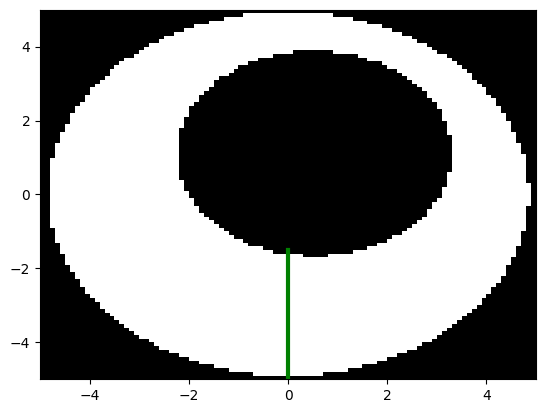

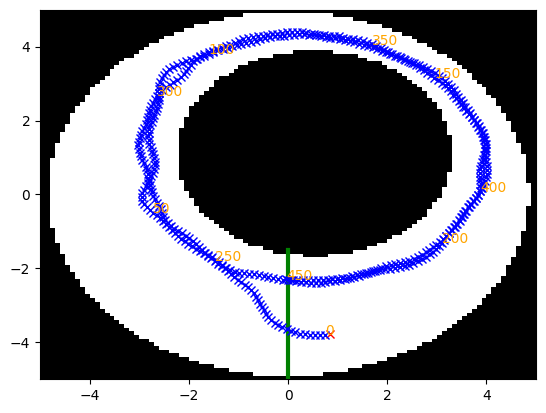

num timesteps used: 450


In [9]:
def run_planner_on_racetrack(
    env: gymnasium.Env,
    planner_class=MPPIRacetrack,
    seed: int = 0,
    num_laps: int = 3,
) -> int:
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        env.unwrapped.finish_line[:, 0],
        env.unwrapped.finish_line[:, 1],
        "g",
        lw=3,
    )
    np.random.seed(seed)
    obs, _ = env.reset()
    env.unwrapped.laps_left = num_laps

    # Create an instance of your planner
    planner = planner_class(static_map=env.unwrapped.map)

    # Draw a map of the environment with the finish line + initial position
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        env.unwrapped.finish_line[:, 0],
        env.unwrapped.finish_line[:, 1],
        "g",
        lw=3,
    )
    ax.plot(obs[0], obs[1], "rx")
    print("Initial position:", obs)
    
    # Run the environment for num_timesteps, unless the robot hits an obstacle
    # or successfully completes the number of laps needed
    num_timesteps = 500
    success = False
    for t in range(num_timesteps):
        action = planner.get_action(obs)
        # print("Action:", action)
        obs, _, terminated, _, _ = env.step(action)

        ax.plot(obs[0], obs[1], "bx")
        # print("Position:", obs)
        if t % 50 == 0:
            # print(f"Timestamp {t}: Position {obs}")
            ax.text(obs[0], obs[1], str(t), fontsize=10, color="orange")

        if terminated:
            success = True
            break

    num_timesteps_used = t

    plt.show()

    if success:
        return num_timesteps_used
    else:
        return -1


seed = 0
num_laps = 3
planner_class = MPPIRacetrack
num_timesteps_used = run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)
print(f"num timesteps used: {num_timesteps_used}")

## [Extra Credit] 1c) Compete for the fastest lap time

In this part, you can earn extra credit by achieving faster lap times (measured in average number of steps to complete the course, not computational runtime). You can get some extra credit by implementing a working version of something interesting here (e.g., another planning algorithm, a learning-based method, an extension beyond the basic MPPI we discussed in class). We will give additional extra credit to the student with the fastest lap time, which can be monitored on the Gradescope leaderboard.

### Better Planner Strategy
The BetterPlanner uses two controllers for different track sections:

1. **Proportional Controller**:  
   - Drives the robot from the start to a **tangential point**.  
   - The tangential point is selected from precomputed waypoints (obtained via the wall-hugging controller) based on proximity to an ideal tangential trajectory.  

2. **Wall-Hugging MPPI Controller**:  
   - Maintains the robot near the track center while avoiding collisions.  

This approach ensures a smooth transition from the start to an optimized racing trajectory.


In [10]:
def find_closest_angle_point(given_point):
    position_list = np.array([
        [-0.08625366, -1.680265, -3.39215363], [-0.183131, -1.65547025, -3.43698671],
        [-0.27879975, -1.62635857, -3.47101993], [-0.37342253, -1.59400845, -3.499179],
        [-0.46709697, -1.55900702, -3.53633703], [-0.55940646, -1.5205498, -3.57251132],
        [-0.6502647, -1.47877923, -3.59009332], [-0.74037452, -1.43541774, -3.6250434],
        [-0.82891414, -1.38893401, -3.67242762], [-0.91515261, -1.33830866, -3.70694646],
        [-0.99959252, -1.2847372, -3.75064304], [-1.08161168, -1.22752831, -3.78454769],
        [-1.16164444, -1.16757201, -3.83371231], [-1.23863394, -1.10375495, -3.86474001],
        [-1.31360661, -1.03758019, -3.89882668], [-1.38628049, -0.9688888, -3.91448154],
        [-1.45787015, -0.89906817, -3.94950328], [-1.52697117, -0.82678367, -3.99009869],
        [-1.59308165, -0.75175431, -4.01389058], [-1.6573885, -0.67517345, -4.04478037],
        [-1.71929948, -0.596643, -4.06343212], [-1.77973504, -0.51697154, -4.09952231],
        [-1.83725652, -0.43517129, -4.10987238], [-1.89392829, -0.35278009, -4.16355373],
        [-1.94609768, -0.26746682, -4.20946691], [-1.99429647, -0.17984903, -4.24861797],
        [-2.03902886, -0.09041183, -4.27940048], [-2.08098740, 0.000359761247, -4.32639030],
        [-2.11863585, 0.09300205, -4.37727241], [-2.15152378, 0.18743925, -4.42790038],
        [-2.17959044, 0.28341978, -4.47596489], [-2.20301321, 0.38063796, -4.52142716],
        [-2.22199354, 0.47882017, -4.58974042], [-2.23422767, 0.57806898, -4.64171973],
        [-2.24128872, 0.67781938, -4.66418104]
    ])

    x0, y0 = given_point
    angles = np.arctan2(position_list[:, 1] - y0, position_list[:, 0] - x0)
    angle_diffs = np.abs((angles - position_list[:, 2] + np.pi) % (2 * np.pi) - np.pi)
    
    return position_list[np.argmin(angle_diffs)]


class BetterPlanner:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
        no_of_rollouts=300,  # Reduced for efficiency
        v_limits=[0, 1],
        w_limits=[-2 * np.pi, 2 * np.pi],
        lam=60,
        t=7,
        ellipse_center=(0.5, 1),  # Center of the elliptical track
    ):
        self.motion_model = motion_model
        self.static_map = static_map
        self.no_of_rollouts = no_of_rollouts
        self.v_limits = v_limits
        self.w_limits = w_limits
        self.lam = lam
        self.t = t
        self.last_control = np.array([1, -1])
        self.ellipse_center = ellipse_center
        self.mppi_flag = False
        self.goal = None

    def control_disturbance_matrix(self):
        """
        Generate a matrix of control disturbances for all rollouts.
        """
        return np.random.normal(0, [0, np.pi / 4], size=(self.no_of_rollouts, self.t, 2))

    def score_rollouts(self, control_sequences, initial_state):
        """
        Score each control sequence based on distance to the center
        """
        scores = np.zeros(self.no_of_rollouts)
        h, k = self.ellipse_center  # Ellipse center coordinates

        for i, control_sequence in enumerate(control_sequences):
            state = initial_state
            score = 0

            for control in control_sequence:
                # Simulate the motion
                state = self.motion_model.step(state, control, 0.1)

                # Collision check (early exit for collisions)
                map_indices = self.static_map.world_coordinates_to_map_indices(state[:2])
                if self.static_map.static_map[map_indices[0][0]][map_indices[0][1]]:
                    score += 1e8  # Large penalty for collisions
                    break

                # Distance to center
                distance_to_center = np.linalg.norm(state[:2] - self.ellipse_center)

                # Orientation penalty
                # robot_angle = state[2]  # Robot orientation (theta)
                # direction_to_center = np.arctan2(k - state[1], h - state[0])  # Angle to the center
                # perpendicular_angle = direction_to_center + np.pi / 2  # Perpendicular orientation
                # angle_deviation = (robot_angle - perpendicular_angle - np.pi) % (2 * np.pi) - np.pi
                # control_change_penalty = np.linalg.norm(control[1] - self.last_control[1])
                # Total score
                # score += distance_to_center * 350 + abs(angle_deviation) * 0 + control_change_penalty * 0
                score += distance_to_center * 1000

            scores[i] = score

        return scores

    def get_action(self, initial_state):
        """
        Compute the optimal action to navigate the track as quickly as possible.
        """
        x, y, theta = initial_state
        if self.goal is None:
            self.goal = find_closest_angle_point(initial_state[:2])
            print(f"Goal: {self.goal}")
        
        goal_x, goal_y = self.goal[0], self.goal[1]-0.1
        threshold_distance = 0.3  

        distance_to_goal = np.linalg.norm([x - goal_x, y - goal_y])

        if distance_to_goal < threshold_distance:
            self.mppi_flag = True

        if not self.mppi_flag:
            angle_to_goal = np.arctan2(goal_y - y, goal_x - x)
            angular_error = angle_to_goal - theta
            angular_error = (angular_error + np.pi) % (2 * np.pi) - np.pi
            w = np.clip(10 * angular_error, -2 * np.pi, 2 * np.pi)
            return np.array([1, w])

        nominal_control_sequence = np.tile(self.last_control, (self.t, 1))
        control_sequences = nominal_control_sequence + self.control_disturbance_matrix()
        control_sequences[:, :, 0] = np.clip(control_sequences[:, :, 0], self.v_limits[0], self.v_limits[1])  # v
        control_sequences[:, :, 1] = np.clip(control_sequences[:, :, 1], self.w_limits[0], self.w_limits[1])  # w

        scores = self.score_rollouts(control_sequences, initial_state)
        # print(min(scores))
        scores = scores - np.min(scores)
        # print((scores))
        weights = np.exp(-scores / self.lam)
        weights /= np.sum(weights)
        delta_u = control_sequences - nominal_control_sequence
        merged_sequence = nominal_control_sequence + np.sum((weights[:, None, None] * delta_u), axis=0)

        self.last_control = merged_sequence[0]
        return merged_sequence[0]



Initial position: [ 0.8392881  -3.78481063  3.24435603]
Goal: [-1.6573885  -0.67517345 -4.04478037]
lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed


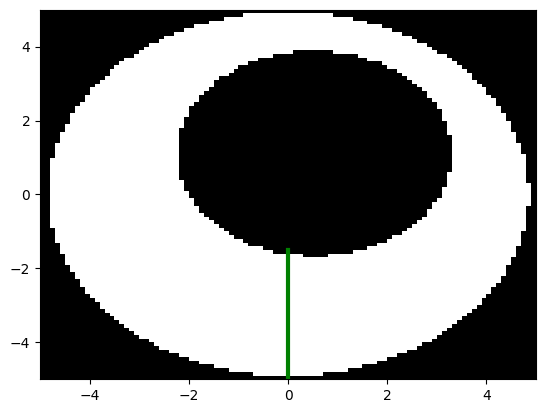

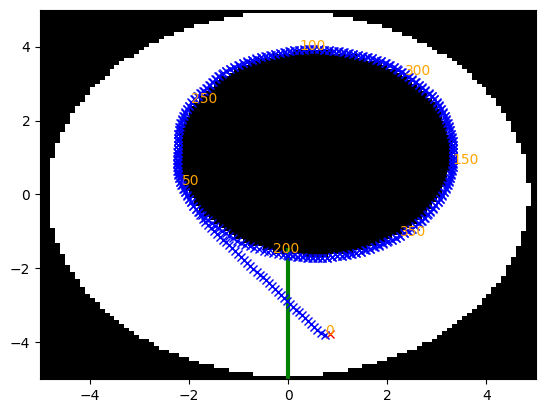

374

In [11]:
seed = 0
num_laps = 3
planner_class = BetterPlanner
run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)

# Problem 2: Trajectory Optimization with `cvxpy`

## 2a) Double Integrator: Initial & Terminal Conditions

For this problem, you'll use the 2D discrete-time double integrator dynamics, where $$\mathbf{x}[t] = \begin{bmatrix}
x[t]\\
y[t]\\
v_x[t]\\
v_y[t]\\
\end{bmatrix}, \quad \mathbf{u}[t] = \begin{bmatrix} a_x[t]\\ a_y[t]\\ \end{bmatrix}, \quad \mathbf{x}[t+dt] = A \mathbf{x}[t] +  B \mathbf{u}[t], \quad A = \begin{bmatrix}
1 & 0 & dt & 0 \\
0 & 1 & 0 & dt \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \quad B = \begin{bmatrix}
\frac{dt^2}{2} & 0 \\
0 & \frac{dt^2}{2} \\
dt & 0 \\
0 & dt \\
\end{bmatrix}.
$$

You should turn the following optimization problem into code:

$$
\begin{align}
\min_{x_{0:T}, u_{0:T}}\quad & (x[T] - g_x)^2 + (y[T] - g_y)^2 \\
\text{s.t.}\quad & \mathbf{x}[t+1] = A \mathbf{x}[t] + B \mathbf{u}[t] \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{u}[t] \in U \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{x}[0] = \mathbf{x}_0 \\
& v_x[T] = v_{x,T} \\
& v_x[T] = v_{y,T} \\
\end{align}
$$

with $g_x = 3, g_y=5, v_{x,T}=0, v_{y,T}=0, \mathbf{x}_0 = [1, 2, 0, 0], U = [-1, 1] \times [-1, 1], T=10$.

**Deliverables**:
- Implement `optimize_trajectory`, which will take in initial and terminal conditions, control limits, dt, and return the optimal sequence of states (i.e., an array of shape (T+1, 4) -- T+1 timesteps (T timesteps + the initial state) and 4 states per timestep)
- Generate a plot of your optimal trajectory. You are welcome to use the `plot_trajectory` function or write your own version.

In [12]:
def optimize_trajectory(
    initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
    T: int = 10,
) -> np.ndarray:
    A = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ])

    B = np.array([
        [0.5 * dt**2, 0],
        [0, 0.5 * dt**2],
        [dt, 0],
        [0, dt],
    ])

    x0 = np.hstack((initial_pos, initial_vel))
    xT = np.hstack((goal_pos, goal_vel))

    # Variables
    x = cp.Variable((T + 1, 4))  # States
    u = cp.Variable((T, 2))      # Controls

    objective = cp.Minimize(cp.sum_squares(x[T, :2] - goal_pos))

    constraints = []

    constraints.append(x[0] == x0)

    for t in range(T):
        constraints.append(x[t + 1] == A @ x[t] + B @ u[t])

    # Control limits
    constraints.append(u[:, 0] >= u_limits[0, 0])
    constraints.append(u[:, 0] <= u_limits[0, 1])
    constraints.append(u[:, 1] >= u_limits[1, 0])
    constraints.append(u[:, 1] <= u_limits[1, 1])

    # Final condition
    constraints.append(x[T, 2:] == goal_vel)

    problem = cp.Problem(objective, constraints)
    problem.solve()

    states = x.value
    return states

def plot_trajectory(xt: np.ndarray) -> None:
    plt.plot(xt[:, 0], xt[:, 1], "-x")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Optimized Trajectory")
    plt.axis("equal")
    plt.grid()
    plt.show()

You can check whether your code works using

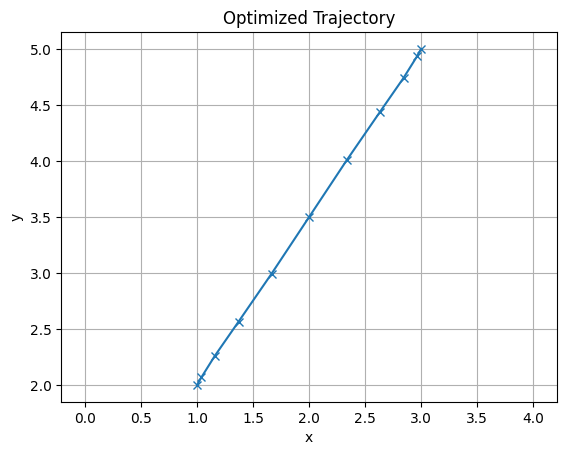

In [13]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

optimal_xt = optimize_trajectory(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
)
# print(optimal_xt)    
plot_trajectory(optimal_xt)

## [Extra Credit] 2b) Incorporate obstacle avoidance as a convex optimization problem

Now, you should extend your optimization code to handle a list of circular obstacles that the double integrator must avoid. We would like you to try to keep this as a convex optimization problem. If you just start adding constraints and costs, you will likely end up with a non-convex optimization problem, which are generally hard to solve.

One possible way to keep the problem convex could be to break the free (i.e., non-obstacle) space into a set of convex regions, then split the trajectory into multiple segments (each one needing to stay within one convex region). But, there could be many other ways, and you are encouraged to try different strategies!


### Obstacle Avoidance Strategy

1. **Obstacle-Avoiding Path with A* Quadratic**:  
   - A denser **quadratic version** of A* is used, particularly near the start and goal, aiming to better approximate a **double integrator** motion model (though its impact is uncertain over that of a usual linear grid A*).  

2. **Waypoint Selection**:  
   - From the A* path, a subset of waypoints is chosen based on **curvature** and **spacing** to best represent the A* path.  

3. **Objective Function**:  
   - Minimizes the distance to the selected waypoints at specific timestamps and the distance to the goal.  
   - There are **no strict constraints** enforcing obstacle avoidance, but the trajectory naturally avoids obstacles due to the waypoints selected.


In [14]:
import heapq
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

def a_star_quadratic(start, goal, obstacles, bias_points, grid_size=0.3):
    """
    A* pathfinding algorithm with quadratic bias toward two points.

    Returns a list of waypoints [(x, y), ...] avoiding obstacles.
    """
    def heuristic(n, goal, bias_points):
        p1, p2 = bias_points
        return min(np.linalg.norm(np.array(n) - np.array(p1))**2,
                   np.linalg.norm(np.array(n) - np.array(p2))**2) + np.linalg.norm(np.array(n) - np.array(goal))

    def neighbors(node):
        x, y = node
        moves = [(grid_size, 0), (-grid_size, 0), (0, grid_size), (0, -grid_size)]
        return [(x + dx, y + dy) for dx, dy in moves]

    def is_valid(point):
        for obs in obstacles:
            ox, oy, r = obs
            if np.linalg.norm(np.array(point) - np.array([ox, oy])) < r + grid_size:
                return False
        return True

    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal, bias_points)}

    while open_set:
        _, current = heapq.heappop(open_set)

        if np.linalg.norm(np.array(current) - np.array(goal)) < grid_size:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path

        for neighbor in neighbors(current):
            if not is_valid(neighbor):
                continue

            tentative_g_score = g_score[current] + np.linalg.norm(np.array(current) - np.array(neighbor))

            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal, bias_points)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return []  # No valid path found


def select_smart_waypoints(a_star_path, num_waypoints):
    """ 
    Selects key waypoints by:
    - Prioritizing turns
    - Spacing waypoints effectively
    """
    if len(a_star_path) <= num_waypoints:
        return a_star_path  # Use all points if few exist

    # Compute curvature-based importance of waypoints
    curvatures = []
    for i in range(1, len(a_star_path) - 1):
        prev, curr, nxt = np.array(a_star_path[i - 1]), np.array(a_star_path[i]), np.array(a_star_path[i + 1])
        v1, v2 = curr - prev, nxt - curr
        angle = np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1, 1))
        curvatures.append((angle, i))  # Store (curvature, index)

    # Sort by curvature importance
    curvatures.sort(reverse=True, key=lambda x: x[0])
    key_indices = [i for _, i in curvatures[:num_waypoints - 2]]  # Pick top `num_waypoints-2` important points
    key_indices = sorted([0] + key_indices + [len(a_star_path) - 1])  # Include start and end

    return [a_star_path[i] for i in key_indices]


def optimize_trajectory_with_obstacles(
    initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
    obstacles: list,
    T: int = 10,
) -> np.ndarray:
    """ Optimizes trajectory while approximately following A* path """
    
    # Generate A* path with quadratic bias
    a_star_path = a_star_quadratic(tuple(initial_pos), tuple(goal_pos), obstacles, [tuple(initial_pos), tuple(goal_pos)])
    
    # Select key waypoints smartly
    num_waypoints = 7
    selected_waypoints = select_smart_waypoints(a_star_path, num_waypoints)
    
    # Distribute time steps **non-linearly**
    time_steps = np.linspace(1, T - 1, len(selected_waypoints), dtype=int)
    waypoints = [(np.array(wp), t) for wp, t in zip(selected_waypoints, time_steps)]
    # waypoints = waypoints[1:-1]
    # print("Generated waypoints:", waypoints)

    # State transition matrices
    A = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ])
    B = np.array([
        [0.5 * dt**2, 0],
        [0, 0.5 * dt**2],
        [dt, 0],
        [0, dt],
    ])

    x0 = np.hstack((initial_pos, initial_vel))
    xT = np.hstack((goal_pos, goal_vel))

    # Variables
    x = cp.Variable((T + 1, 4))  # States
    u = cp.Variable((T, 2))      # Controls

    # Objective function: Minimize distance from goal and waypoints
    objective = cp.Minimize(
    5 * cp.sum_squares(x[T, :2] - goal_pos)  # Stronger weight on final goal
    + 2* sum(cp.sum_squares(x[t, :2] - wp) for wp, t in waypoints)  # Soft waypoint penalties
)

    constraints = [x[0] == x0]

    for t in range(T):
        constraints.append(x[t + 1] == A @ x[t] + B @ u[t])

    # Control limits
    constraints.append(u[:, 0] >= u_limits[0, 0])
    constraints.append(u[:, 0] <= u_limits[0, 1])
    constraints.append(u[:, 1] >= u_limits[1, 0])
    constraints.append(u[:, 1] <= u_limits[1, 1])
    constraints.append(x[T, :2] == goal_pos)  # Strictly enforce final position
    constraints.append(x[T, 2:] == goal_vel)  # Enforce final velocity
    
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    states = x.value
    return states


def plot_trajectory_with_obstacles(xt: np.ndarray, obstacles: list[np.ndarray], a_star_path: list = []):
    fig, ax = plt.subplots()

    # Plot optimized trajectory
    plt.plot(xt[:, 0], xt[:, 1], "-x", label="Optimized Trajectory", color="blue")

    # Plot A* path
    if a_star_path:
        a_star_path = np.array(a_star_path)
        plt.plot(a_star_path[:, 0], a_star_path[:, 1], "--", label="A* Path", color="gray", alpha=0.7)

    # Plot obstacles
    for obstacle in obstacles:
        ax.add_patch(plt.Circle(obstacle[:2], obstacle[2], color="r", alpha=0.5, label="Obstacle"))

    plt.axis("equal")
    plt.legend()
    plt.show()


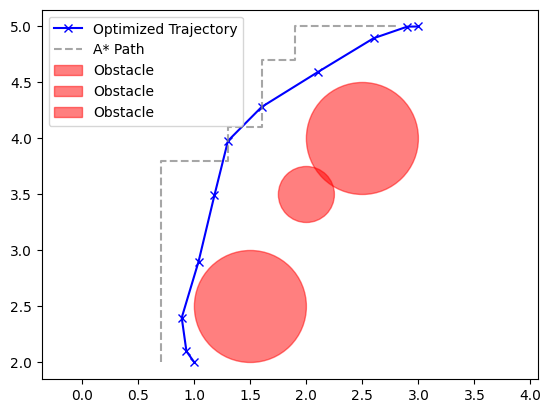

In [15]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

obstacles = [
    (1.5, 2.5, 0.5),
    (2.0, 3.5, 0.25),
    (2.5, 4.0, 0.5),
]


optimal_xt = optimize_trajectory_with_obstacles(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
    obstacles
)
a_star_path = a_star_quadratic(tuple(initial_pos), tuple(goal_pos), obstacles, [tuple(initial_pos), tuple(goal_pos)])
# print(optimal_xt)

plot_trajectory_with_obstacles(optimal_xt, obstacles, a_star_path=a_star_path)